# Loading preprocessed data

In [107]:
import numpy as np
import math
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from keras.layers import CuDNNLSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

In [108]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(CuDNNLSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [109]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

### import training and validation data (not included in repo)

In [139]:
path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(path+'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(path+'data/Y_train.npy')
X_val = np.load(path+'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(path+'data/Y_val.npy')

In [111]:
X_train.shape
# (58284, 122, 85, 1) -> (n_samples, frequencies, timestamps, 1)

(58284, 85, 122, 1)

In [141]:
path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
binary_classes = ['known', 'unknown']
print(all_classes, '-->', binary_classes)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'zero', 'wow', 'two', 'tree', 'three', 'six', 'sheila', 'seven', 'one', 'nine', 'marvin', 'house', 'happy', 'four', 'five', 'eight', 'dog', 'cat', 'bird', 'bed'] --> ['known', 'unknown']


In [140]:
def binarize_classes(set):
   for i, class_idx in enumerate(set):
      if classes[class_idx] == 'unknown':
         set[i] = 1
      else:
         set[i] = 0
binarize_classes(Y_train)
binarize_classes(Y_val)


11
1


In [113]:
# for label in all_classes:
#    print(data[label].shape, ':)')

### The training data is very unbalanced with a much larger 'unknown' class. Keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [142]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights = get_class_weights(Y_train)


In [143]:
class_weights

{1: 1.0, 0: 1.715177489984161}

some constants we need for all models

In [144]:
input_size = X_train.shape[1:]
batch_size = 196

## The ResNet
### declare filters for each block of blocks and set output size.

In [148]:
filters_list = [8,16,32]
output_size = 2

In [149]:
#adjust these strings for organizeing the saved files
date = '20220431'
arch = 'resnetlstm8_16_32_128_binary'

### Build the model

In [151]:
sr = ResNetLstm(filters_list, input_size, output_size)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)
7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)


In [152]:
sr.m.summary()
# Total params: 80,540
# Trainable params: 79,868
# Non-trainable params: 672

# Total params: 286,748
# Trainable params: 285,820
# Non-trainable params: 928

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 85, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 85, 122, 8)   80          ['input[0][0]']                  
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 85, 40, 8)   0           ['conv2d_63[0][0]']              
                                                                                                  
 batch_normalization_57 (BatchN  (None, 85, 40, 8)   32          ['max_pooling2d_9[0][0]']  

In [17]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [156]:
def step_decay(epoch):
   initial_lrate = 1
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 600
   epochs_of_fast_decaying = 200
   lrate = initial_lrate * math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying + math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

In [157]:
#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

### Load model weights (optional)

In [158]:
!ls /home2/faculty/kmrozowski/models/

resnetlstm8_16_32_128_20220430_best.h5	resnetlstm8_16_32_128_20220431_best.h5


In [22]:
path = '/home2/faculty/kmrozowski/models/'
sr.m.load_weights(path + 'resnetlstm8_16_32_128_20220431_best.h5')

### Train the model. The history object stores training data for later access, like plotting training curves

In [159]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train), 
                   batch_size = batch_size, 
                   epochs = 1000,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights,
                   validation_data = (X_val, to_categorical(Y_val)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

/mnt/evafs/faculty/home/kmrozowski/rl2/inkub-env/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
298/298 [==============================] - ETA: 0s - loss: 0.6464 - accuracy: 0.7379WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa7d418a7a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 

### Plot the training graphs, and save them

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


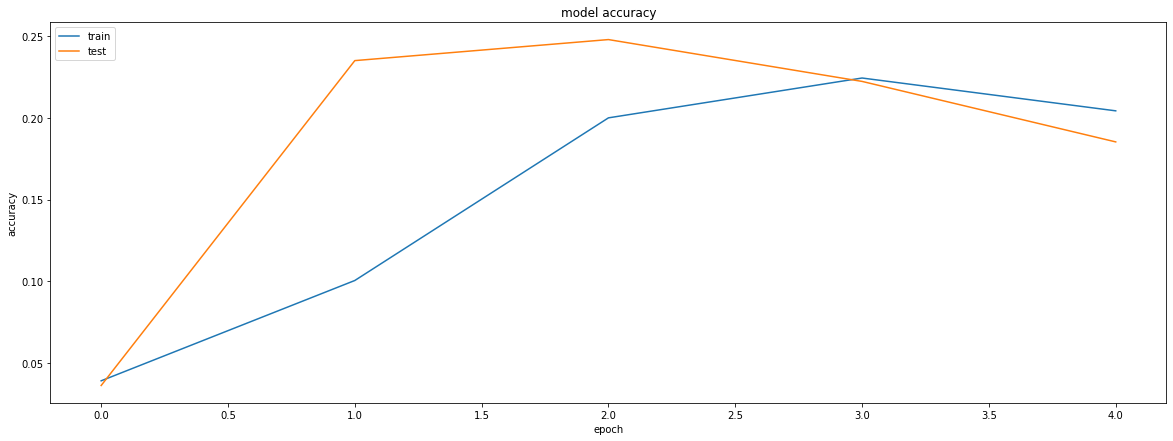

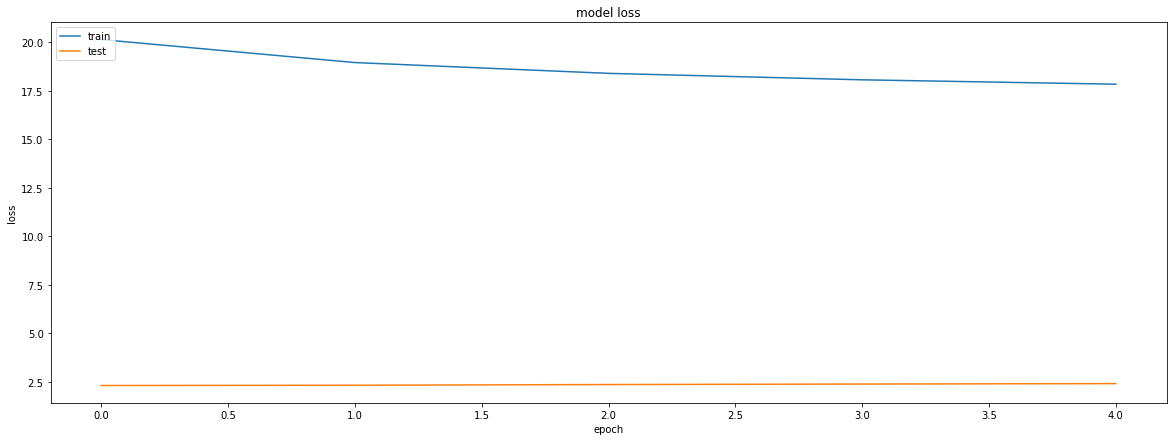

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

### Predict the validation classification and score

In [23]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-05-01 14:54:19.892759: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-05-01 14:54:20.773115: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/35 [..............................] - ETA: 1:38

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2022-05-01 14:54:21.395266: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


35/35 [==============================] - 4s 18ms/step


In [24]:
print(classification_report(Y_val, np.argmax(val_pred, axis = 1), target_names = classes, digits = 3))

              precision    recall  f1-score   support

         yes      0.939     0.943     0.941       261
          no      0.837     0.874     0.855       270
          up      0.849     0.888     0.868       260
        down      0.936     0.833     0.882       264
        left      0.921     0.895     0.908       247
       right      0.869     0.906     0.887       256
          on      0.768     0.926     0.840       257
         off      0.865     0.875     0.870       256
        stop      0.884     0.894     0.889       246
          go      0.772     0.835     0.802       260
     silence      0.932     1.000     0.965        41
     unknown      0.966     0.947     0.956      4221

    accuracy                          0.924      6839
   macro avg      0.878     0.901     0.889      6839
weighted avg      0.927     0.924     0.925      6839



In [25]:
print(confusion_matrix(Y_val, np.argmax(val_pred, axis = 1)))

[[ 246    0    0    0    2    2    0    0    0    3    0    8]
 [   0  236    2    1    1    0    2    1    1   11    0   15]
 [   0    2  231    1    0    0    2    4    3    1    0   16]
 [   0   12    0  220    0    0    0    1    1   12    0   18]
 [   7    1    0    0  221    1    0    1    2    1    0   13]
 [   0    0    1    0    1  232    0    0    0    0    0   22]
 [   0    1    1    0    1    1  238    1    0    1    0   13]
 [   0    0   15    0    0    0   11  224    0    2    0    4]
 [   0    0    4    2    0    0    0    3  220    1    0   16]
 [   0    9    2    3    0    2    2    3    3  217    2   17]
 [   0    0    0    0    0    0    0    0    0    0   41    0]
 [   9   21   16    8   14   29   55   21   19   32    1 3996]]


In [41]:
!pip install seaborn
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 36.7 MB/s eta 0:00:0000:0100:01


In [52]:
cf_mat = confusion_matrix(Y_val, np.argmax(val_pred, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]-1):
   for j in range(cf_mat.shape[0]-1):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

acc = 0.9394184168012925


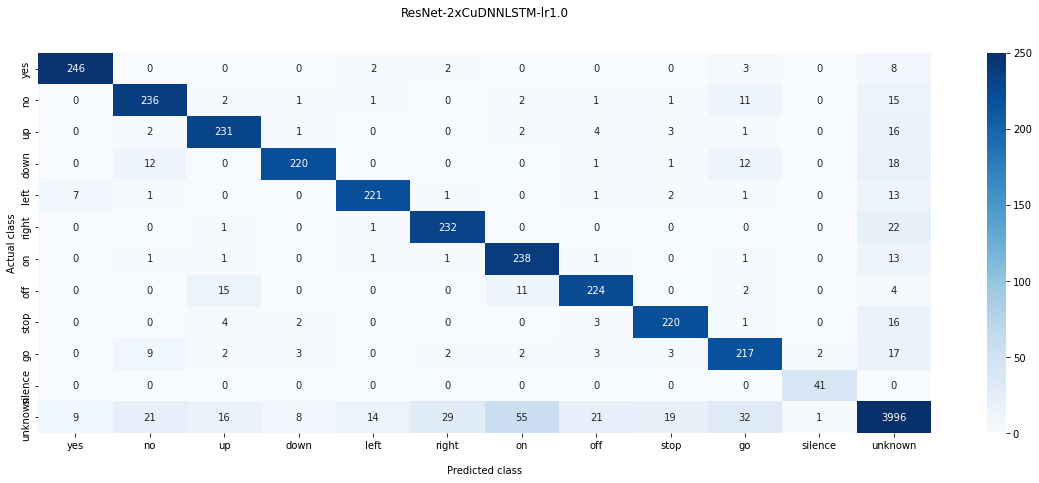

In [53]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=250)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()

### convert spectrogram to audio (doesn't work D: )

down != stop (122, 85, 1) 1019 (5082,)


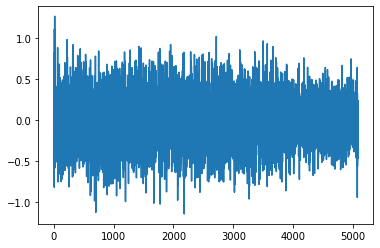

In [106]:
errors_path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/data/errors/'
for actual_label in range(cf_mat.shape[0]):
   for predicted_label in range(cf_mat.shape[1]):
      err_name = classes[actual_label] + '_' + classes[predicted_label]
for i, (x, actual_label, predicted_label) in enumerate(zip(X_val, Y_val, np.argmax(val_pred, axis = 1))):
   if i < 1000:
      continue
   if actual_label != predicted_label:
      if classes[actual_label] == 'unknown' or classes[predicted_label] == 'unknown':
         continue
      err_name = classes[actual_label] + '_' + classes[predicted_label]
      if not os.path.exists(errors_path + err_name):
            os.makedirs(errors_path + err_name)
      # audio_signal = librosa.feature.inverse.mel_to_audio(x.transpose([1,0,2])[:,:,0], sr=16000)
      audio_signal = librosa.core.spectrum.griffinlim(x.transpose([1,0,2])[:,:,0])
      print(classes[actual_label] + ' != ' + classes[predicted_label], x.transpose([1,0,2]).shape, i, audio_signal.shape)
      output_path = errors_path + err_name + '/error_' + str(i) + '.wav'
      sf.write(output_path, audio_signal, 16000, format='wav')
      plt.plot(audio_signal)
      break

   